https://www.tensorflow.org/tutorials/images/transfer_learning
https://www.tensorflow.org/guide/keras/transfer_learning

In [1]:
! pip install -r requirements.txt

  Using cached https://storage.googleapis.com/tensorflow/linux/gpu/tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.3 MB)

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


Train dir: /home/gitpod/.keras/datasets/cats_and_dogs_filtered/train
Validation dir: /home/gitpod/.keras/datasets/cats_and_dogs_filtered/validation
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


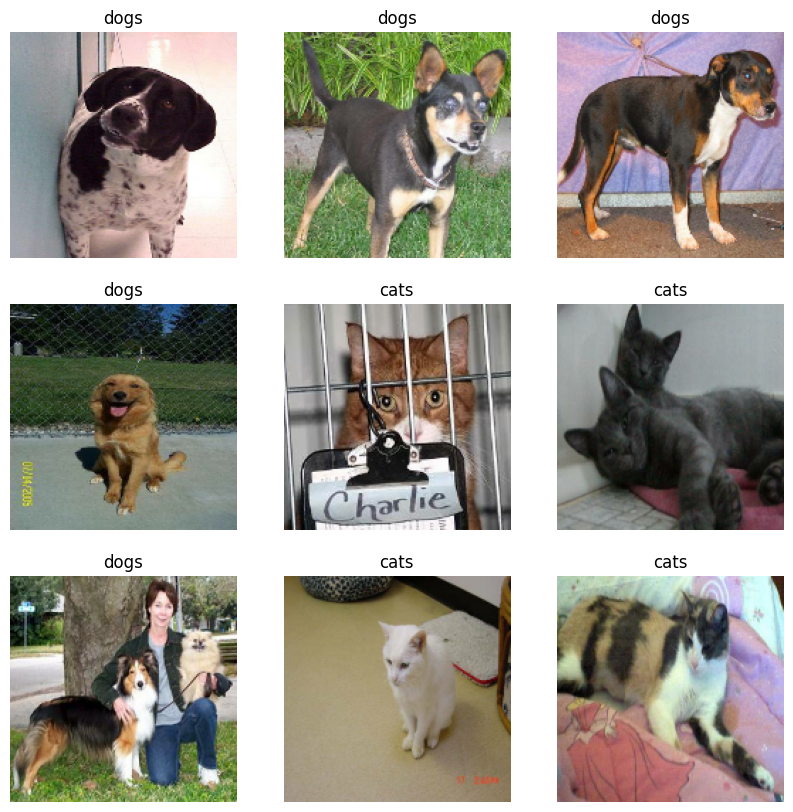

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print(f"Train dir: {train_dir}")
print(f"Validation dir: {validation_dir}")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [44]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

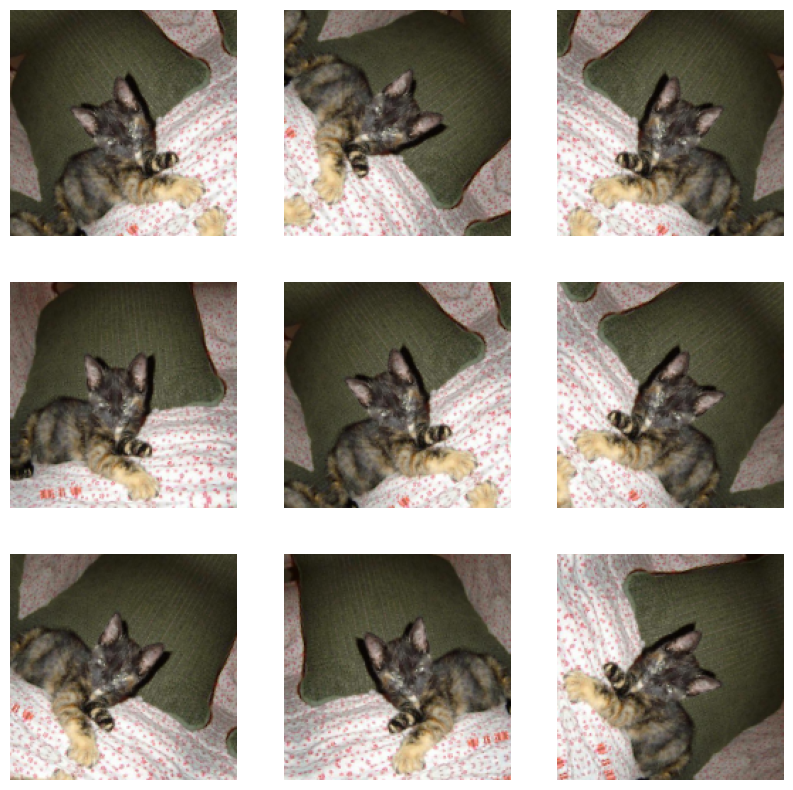

In [46]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

plt.figure(figsize=(10, 10))
for image, _ in train_dataset.take(1):
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Load Model

In [47]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
 
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet') 
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [48]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5, 5, 1280)
(32, 1280)
(32, 1)


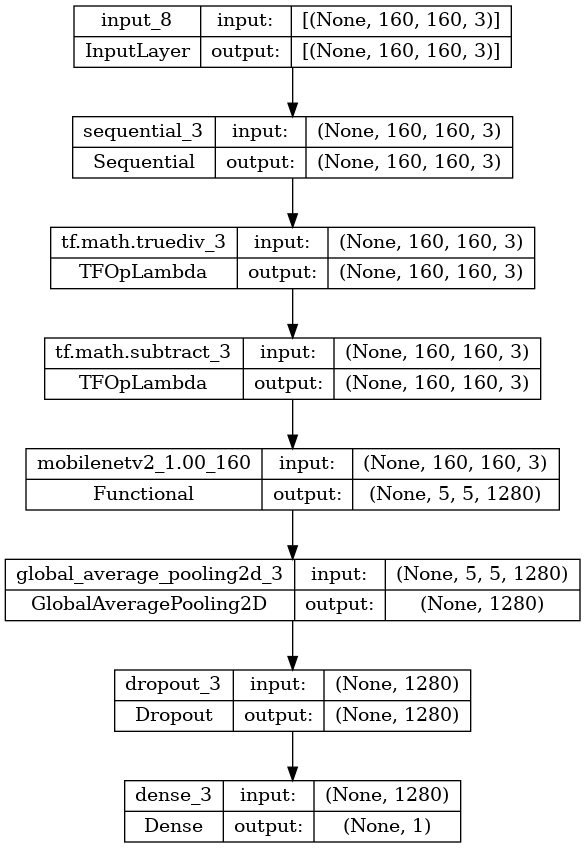

In [49]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
tf.keras.utils.plot_model(model, show_shapes=True)

In [50]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')]
)

# Train classifier

In [51]:
initial_epochs=10
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 9s 297ms/step - loss: 0.7645 - accuracy: 0.5050
initial loss: 0.76
initial accuracy: 0.50


In [52]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 52s 776ms/step - loss: 0.6912 - accuracy: 0.5915 - val_loss: 0.5089 - val_accuracy: 0.7723
Epoch 2/10
63/63 [==============================] - 50s 802ms/step - loss: 0.5150 - accuracy: 0.7500 - val_loss: 0.3774 - val_accuracy: 0.8874
Epoch 3/10
63/63 [==============================] - 34s 536ms/step - loss: 0.4185 - accuracy: 0.8260 - val_loss: 0.2879 - val_accuracy: 0.9319
Epoch 4/10
63/63 [==============================] - 48s 757ms/step - loss: 0.3503 - accuracy: 0.8660 - val_loss: 0.2380 - val_accuracy: 0.9480
Epoch 5/10
63/63 [==============================] - 45s 721ms/step - loss: 0.3198 - accuracy: 0.8795 - val_loss: 0.2052 - val_accuracy: 0.9455
Epoch 6/10
63/63 [==============================] - 43s 688ms/step - loss: 0.2809 - accuracy: 0.9020 - val_loss: 0.1764 - val_accuracy: 0.9505
Epoch 7/10
63/63 [==============================] - 45s 710ms/step - loss: 0.2606 - accuracy: 0.9010 - val_loss: 0.1596 - val_accuracy: 0.9517
Epoch 8/10

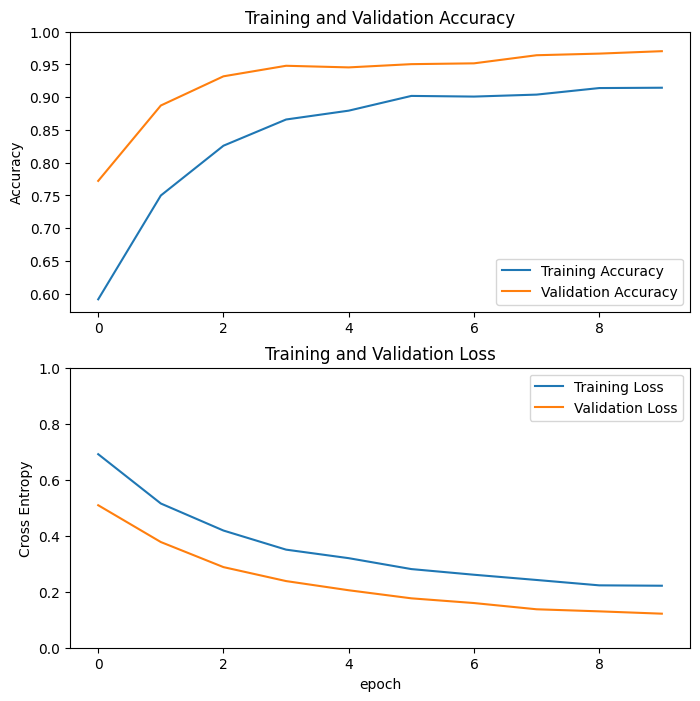

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [55]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset)

Number of layers in the base model:  154
Epoch 10/20
63/63 [==============================] - 62s 905ms/step - loss: 0.1474 - accuracy: 0.9375 - val_loss: 0.0638 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 62s 991ms/step - loss: 0.1187 - accuracy: 0.9500 - val_loss: 0.0463 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 59s 944ms/step - loss: 0.1096 - accuracy: 0.9510 - val_loss: 0.0453 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 70s 1s/step - loss: 0.0945 - accuracy: 0.9610 - val_loss: 0.0437 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 62s 978ms/step - loss: 0.0883 - accuracy: 0.9635 - val_loss: 0.0425 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 69s 1s/step - loss: 0.0929 - accuracy: 0.9640 - val_loss: 0.0568 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 64s 1s/step - loss: 0.0752 - accuracy: 0.9685 - 

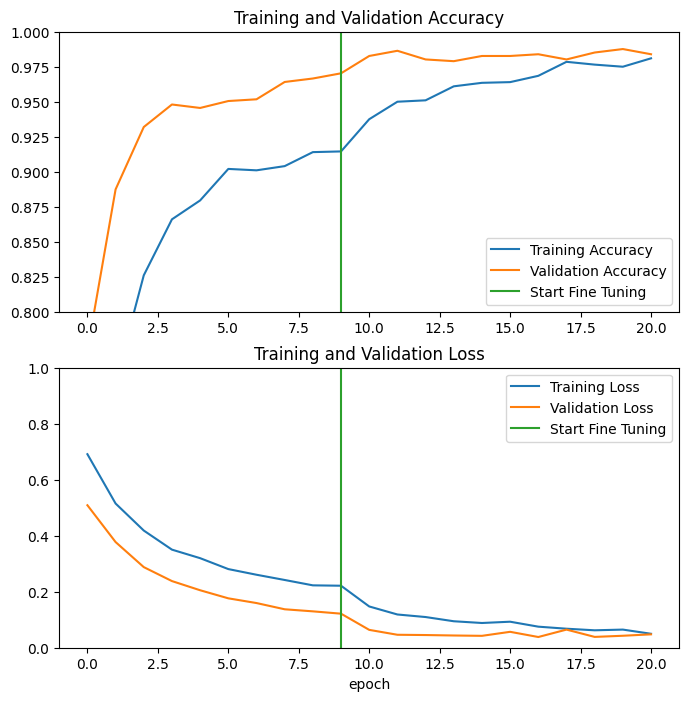

In [56]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate

In [57]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 521ms/step - loss: 0.0518 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1]
Labels:
 [1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1]


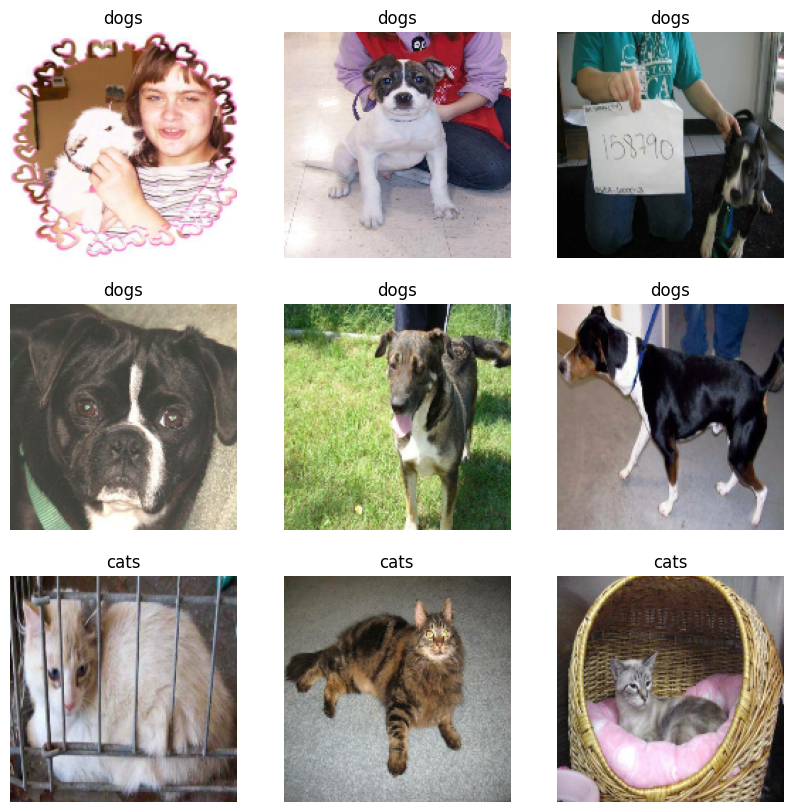

In [58]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")